# Training Welsh Taggers with LSTM

#### This is a simple LSTM implemetation of a tagger used for building Welsh POS and Semantic taggers  

### Step 1: Importing the <code>torch</code>  and other libraries

In [1]:
#torch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)

#other stuff
import numpy as np
import pickle
import glob, os, random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
from timeit import default_timer as timer

### Step 2: Get the helper functions

In [2]:
# Read the data file
def read_data(filepath):
    data = []
    with open(filepath, 'r', encoding="utf8") as f:
        for line in f:
            data.append(tuple(zip(*[wt.split('/') for wt in line.strip().split()])))
    return data

# Get vocabs and tagset
def get_vocab_tagset(data):
    token_size, vocabs, tagset = 0, set(), set()
    for words, tags in data:
        token_size += len(words)
        vocabs.update(words)
        tagset.update(tags)
    return vocabs, tagset, token_size

# convert the sequencies to indexes and tensors
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] if w in to_ix else 0 for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

# indexing list elements: use this for vocabs and tagset
def to_index(aList):
    elem_to_idx = {e:aList.index(e)+1 for e in aList}
    elem_to_idx['Unknown'] = 0  
    idx_to_elem = {i:e for e,i in elem_to_idx.items()}
    return elem_to_idx, idx_to_elem

# import numpy as np
def score_to_tag(tag_scores, i_to_tag):
    tagged=[]
    for preds in tag_scores:
        preds = list(np.array(preds))
        idx = preds.index(max(preds))
        tagged.append(f"{i_to_tag[idx]}")
    return tagged

# tagged_data_file = "../path/to/the/tagged_data_file"
# tagged_data_file = "all_corpora/welsh/cy_pos_coarse_tagged"
tagged_data_file = "all_corpora/welsh/cy_sem_coarse_tagged"
# tagged_data_file = "all_corpora/welsh/cy_both_coarse_tagged"

### Step 3: Preparing the data

In [3]:
# Read training data for each folder
print(f"\nReading {tagged_data_file} ...", end='')
data = read_data(tagged_data_file)
vocabs, tagset, token_size = get_vocab_tagset(data)
tagset = set(t for t in tagset if t) #Just taking care of some null string in tagset

#Uncomment below for data statistics
print(f"\nSentences:\t{len(data)}\nToken size:\t{token_size}\nVocab size:\t{len(vocabs)}\nTagset size:\t{len(tagset)}")

# Shuffle and split data
random.seed(7)
random.shuffle(data)
test_size = 0.1 #90% of data for training; 10% of data for testing
train_set, test_set = data[:-int(len(data)*test_size)], data[-int(len(data)*test_size):]

EMBEDDING_DIM = 100
HIDDEN_DIM = 2
word_to_idx, idx_to_word = to_index(list(vocabs))
tag_to_idx, idx_to_tag = to_index(list(tagset))


Reading all_corpora/welsh/cy_sem_coarse_tagged ...
Sentences:	611
Token size:	14876
Vocab size:	3898
Tagset size:	116


### Step 4: Creating the model

In [4]:
class Tagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(Tagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

### Step 5: Training the model

In [5]:
model = Tagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_idx), len(tag_to_idx))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

start = timer()

NUM_EPOCHS = 500
result_point = 50

ACC, PRE, REC, F1 = [],[],[],[]
print(f"{' '*(NUM_EPOCHS//result_point+8)}\tACC\tPRE\tREC\tF1\n[{'.'*max((NUM_EPOCHS//result_point)-1,1)}", end='')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for epoch in range(NUM_EPOCHS):  # again, normally you would NOT do 300 epochs, it is toy data
        for sentence, tags in train_set:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = prepare_sequence(sentence, word_to_idx)
            targets = prepare_sequence(tags, tag_to_idx)

            # Step 3. Run our forward pass.
            tag_scores = model(sentence_in)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(tag_scores, targets)
            
            loss.backward()
            optimizer.step()

        y_gold, y_pred = [],[]
        with torch.no_grad():
            for sent in test_set:
                y_gold.extend(sent[1])
                inputs = prepare_sequence(sent[0], word_to_idx)
                tag_scores = model(inputs)
                y_pred.extend(score_to_tag(tag_scores, idx_to_tag))

            acc=accuracy_score(y_gold, y_pred)*100
            pre=precision_score(y_gold, y_pred, average='macro')*100
            rec=recall_score(y_gold, y_pred, average='macro')*100
            f1=f1_score(y_gold, y_pred, average='macro')*100
            ACC.append(acc)
            PRE.append(pre)
            REC.append(rec)
            F1.append(f1)

            if epoch%max(NUM_EPOCHS//result_point,1)==0:
                print(f"] Epoch {epoch:003d}: {acc:.2f}",end='\t')
                print(f"{pre:.2f}",end='\t')
                print(f"{rec:.2f}",end='\t')
                print(f"{f1:.2f}\n[", end='')
            elif epoch == NUM_EPOCHS-1:
                print(f".] Epoch {epoch:003d}: {acc:.2f}\t{pre:.2f}\t{rec:.2f}\t{f1:.2f}")
            else:
                print('.',end='')
    
print(f'Done! Runtime: {timer() - start:.2f} secs')

                  	ACC	PRE	REC	F1
[.........] Epoch 000: 37.90	0.92	2.12	1.28
[.........] Epoch 010: 41.18	2.02	2.63	1.96
[.........] Epoch 020: 42.78	2.58	2.98	2.43
[.........] Epoch 030: 42.85	2.49	2.98	2.42
[.........] Epoch 040: 42.98	2.53	3.01	2.46
[.........] Epoch 050: 42.85	2.43	2.98	2.42
[.........] Epoch 060: 42.98	2.46	3.00	2.45
[.........] Epoch 070: 42.91	2.45	2.99	2.44
[.........] Epoch 080: 43.58	3.21	3.12	2.63
[.........] Epoch 090: 44.18	2.71	3.20	2.66
[.........] Epoch 100: 45.12	2.86	3.37	2.82
[.........] Epoch 110: 45.32	2.93	3.39	2.84
[.........] Epoch 120: 45.45	2.94	3.44	2.88
[.........] Epoch 130: 45.52	2.96	3.45	2.90
[.........] Epoch 140: 45.45	2.87	3.44	2.88
[.........] Epoch 150: 45.92	3.00	3.63	3.00
[.........] Epoch 160: 45.72	3.19	4.10	3.19
[.........] Epoch 170: 45.79	3.21	4.10	3.20
[.........] Epoch 180: 45.99	3.50	4.16	3.27
[.........] Epoch 190: 46.06	3.56	4.22	3.28
[.........] Epoch 200: 46.32	3.81	4.30	3.37
[.........] Epoch 210: 46.39	3.61	4.29	3.3

### Testing the Model

In [6]:
test_sentences = [
    "Os gwelwch yn dda, nodwch y testun ar gyfer tagio POS .",
    "Eisiau tagio mwy o destun ?",
    "Diolch am roi cynnig ar ein demo !"
    ]

with torch.no_grad():
    for sent in test_sentences:
        print(sent)
        inputs = prepare_sequence(sent.split(), word_to_idx)
        pred_tags = score_to_tag(model(inputs), idx_to_tag)
        print(" ".join(f"{s}/{t}" for s,t in zip(sent.split(),pred_tags)))
        print('-'*20)

Os gwelwch yn dda, nodwch y testun ar gyfer tagio POS .
Os/Z5 gwelwch/X2 yn/Z5 dda,/Q1 nodwch/A1 y/Z5 testun/Q2 ar/Z5 gyfer/M6 tagio/N1 POS/M6 ./PUNCT
--------------------
Eisiau tagio mwy o destun ?
Eisiau/X2 tagio/Z2 mwy/N3 o/Z5 destun/X2 ?/PUNCT
--------------------
Diolch am roi cynnig ar ein demo !
Diolch/Q2 am/Z5 roi/A1 cynnig/L1 ar/Z5 ein/Z8 demo/N1 !/Z99
--------------------


### Plotting the metrics

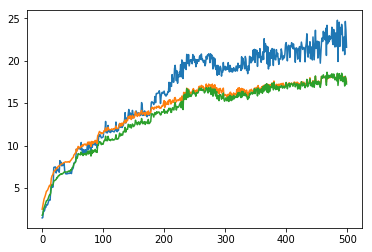

In [7]:
import numpy as np
import matplotlib.pyplot as plt
# plt.plot(ACC)
plt.plot(PRE)
plt.plot(REC)
plt.plot(F1)
plt.show()

### Save the model

In [8]:
DIR, prefix ='tagger', 'sem'

#save model
torch.save(model.state_dict(), f'{DIR}/{prefix}_model.pth')

#dump dictionaries
dicts = word_to_idx, idx_to_word, tag_to_idx, idx_to_tag
pickle.dump(dicts,open(f'{DIR}/{prefix}_dicts.pkl', 'wb'), protocol=2)

# new_model = Tagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_idx), len(tag_to_idx))
# new_model.load_state_dict(torch.load('model/model.pth'))
# model.eval()

In [9]:
'example.txt'[:-3]+'tagged'

'example.tagged'